In [2]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import assemble, Aer, transpile, execute
from qiskit import BasicAer
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import ParameterVector
from qiskit.visualization import *
from qiskit.circuit.library import ZZFeatureMap
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.algorithms import QSVC
from qiskit.algorithms.optimizers import SPSA
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
from qiskit_machine_learning.kernels import QuantumKernel

import sklearn
from sklearn import metrics
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import  StandardScaler,MinMaxScaler,MaxAbsScaler

import pandas as pd
import scipy.stats as stats
from imblearn.combine import SMOTETomek 

from sklearn.metrics import roc_auc_score

import os 
import datetime 
import time
import math

In [3]:
data = pd.read_csv('creditcard.csv')

In [4]:
data['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [5]:
data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [6]:
data_new = data.drop('Time',axis=1)

In [7]:
ct = ColumnTransformer([('scale', MinMaxScaler(),["Amount"])],remainder='passthrough')
data_trans=ct.fit_transform(data_new)
data = pd.DataFrame(data=data_trans,columns = ['Amount','V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',
       'Class'])

In [8]:
data

,Amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,0.005824,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.0
1,0.000105,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0.0
2,0.014739,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0.0
3,0.004807,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.0
4,0.002724,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,0.000030,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.0
284803,0.000965,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0.0
284804,0.002642,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0.0
284805,0.000389,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,0.0


In [10]:
data = data.drop(['V18', 'V19', 'V20','V21','V22','V23','V24','V25','V26','V27','V28'], axis=1)

In [11]:
data

,Amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,Class
0,0.005824,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.0
1,0.000105,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,0.0
2,0.014739,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,0.0
3,0.004807,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,0.0
4,0.002724,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,0.000030,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.0
284803,0.000965,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,0.0
284804,0.002642,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.0
284805,0.000389,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,0.0


In [13]:
features = data.drop('Class',axis=1)
labels = data['Class']
Xtrain, Xtest, Ytrain, Ytest = sklearn.model_selection.train_test_split(features, labels,
                                                                   train_size = 0.5, random_state=45)

In [14]:
## Training
smt = SMOTETomek(random_state=42);
Xtrain_bal, Ytrain_bal = smt.fit_resample(Xtrain,Ytrain)

In [16]:
Xtrain_bal = pd.DataFrame(Xtrain_bal)
Ytrain_bal = pd.DataFrame(Ytrain_bal)
train_bal = pd.concat([Xtrain_bal,Ytrain_bal],axis=1)
train_bal

,Amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,Class
0,0.000005,-0.673264,1.550525,1.948466,2.228277,1.011706,0.187055,1.110159,-0.253576,-0.675808,0.430222,2.554766,-2.228491,1.503230,1.874020,-0.737901,-0.339307,0.547364,0.0
1,0.000195,-1.264334,1.766895,0.596848,0.554130,0.255516,-0.088519,0.388093,0.070170,-0.535381,0.129633,-1.244876,0.471216,1.737508,0.039633,1.064876,0.070773,-0.544254,0.0
2,0.000070,-0.748899,0.950838,0.398237,-0.734195,1.400536,-0.616548,0.910112,-0.075000,-0.775755,-0.970682,1.234001,0.897608,0.601847,-0.914328,-0.960031,0.383894,0.176695,0.0
3,0.001246,2.088107,-1.042366,-0.468295,-0.969029,-1.014973,-0.283226,-1.043842,0.047188,-0.154501,0.863561,0.739969,0.214418,0.181936,-0.256796,-0.410857,1.491758,-0.187875,0.0
4,0.000050,1.194814,0.295576,0.175212,0.443669,0.092142,-0.074669,-0.057289,0.065894,-0.307420,-0.176440,1.671454,1.248387,0.833329,-0.212646,0.597586,0.447573,-0.134531,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284339,0.000031,-0.789664,3.605316,-5.601257,6.552509,2.070037,-1.953354,-1.164084,0.673399,-4.096237,-3.964956,4.633594,-4.704128,-0.532087,-10.232778,0.567576,-0.394898,1.304505,1.0
284340,0.023213,-1.966709,0.129300,-2.183473,2.589217,-3.501869,0.401955,-0.791621,1.005720,-1.334460,-4.295064,2.862947,-3.034962,-0.323836,-4.881216,-0.336690,-3.508966,-4.100371,1.0
284341,0.004647,1.660539,0.700303,-1.692429,4.279787,0.808321,-0.090602,0.117103,-0.001326,-0.768054,0.049235,-0.342532,-0.788201,0.167994,-3.318240,-0.212916,2.005781,1.641799,1.0
284342,0.000596,-3.468738,2.195375,-1.122535,1.823905,-1.007864,-0.913088,-1.782956,-1.459718,0.554432,-0.597369,2.971528,-5.130716,0.107813,-3.354935,0.512676,-3.729317,-6.146611,1.0


In [17]:
train_bal0 = train_bal[train_bal['Class']==0].sample(n=20,random_state=47)
train_bal1 = train_bal[train_bal['Class']==1].sample(n=20,random_state=47)

In [18]:
train = pd.concat([train_bal0,train_bal1])

In [19]:
train

,Amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,Class
65300,3.113133e-03,-0.070127,-0.431661,0.040698,-1.363727,1.237706,3.827133,-0.877100,0.890155,-1.282623,0.816248,0.004679,-1.066006,0.434362,-0.265717,1.916675,1.069396,0.170972,0.0
36386,1.303795e-02,0.670583,-1.638428,-0.207224,-0.288521,-1.162713,-0.295275,-0.021176,-0.061733,-0.985455,0.620177,1.223299,0.368599,-0.782592,0.501094,-0.372951,-1.870274,0.474863,0.0
22162,2.794736e-04,-0.428988,1.212184,1.186331,0.393060,0.116833,-0.873171,0.797480,-0.446520,-0.130506,0.255322,0.044340,0.123710,0.725183,-0.807459,1.216738,-0.006988,0.070917,0.0
46065,7.002409e-04,-0.972512,0.329091,-0.156584,-0.467348,0.372968,-1.101374,0.251693,0.427111,-0.201117,-0.310020,0.572697,0.479023,-1.103926,0.842073,-0.932771,0.200201,-0.345755,0.0
92182,2.335434e-04,-0.609488,-0.149993,1.348549,-3.202694,-0.356991,-0.322717,0.018768,0.038357,-2.475705,0.766293,0.305099,-0.496302,0.427789,-0.435432,-1.467762,-0.254114,-0.015273,0.0
18022,3.892389e-05,-3.480558,-4.744433,-1.246765,1.680101,6.607973,-3.572592,-1.231434,-0.885930,0.826640,1.655011,-1.591688,-1.049950,-1.288896,0.357637,0.531283,-0.536808,-0.972722,0.0
72882,3.837896e-04,2.043276,0.063142,-1.853756,0.219676,0.640908,-0.337679,0.077138,-0.060360,0.277511,-0.209036,0.769126,0.646423,-0.070754,-0.645265,-0.453268,0.630856,0.090918,0.0
61025,7.177566e-04,-1.049035,0.697161,1.680894,-0.052330,-0.564142,-0.071452,-0.090980,0.368522,-1.707112,0.876425,0.603041,-0.174735,-0.492096,0.463477,0.554169,-1.245624,-0.197064,0.0
123786,2.958216e-05,-0.653510,1.183349,2.995455,2.987809,-0.327254,0.576879,-0.039318,0.146325,-0.969597,0.466194,-0.674184,0.502263,1.555982,-0.728067,0.339423,-0.213181,0.163545,0.0
51026,1.389583e-04,-2.730865,-0.575008,0.275010,0.617029,1.707817,-1.684864,-0.056984,0.037297,-0.333509,-0.486493,-0.169355,-0.099086,-0.121573,-0.736483,0.766533,-0.193624,1.153737,0.0


In [20]:
X_train = train.drop('Class',axis=1)
y_train = train['Class']

In [21]:
## Test Data
smt = SMOTETomek(random_state=42);
Xtest_bal, Ytest_bal = smt.fit_resample(Xtest,Ytest)

In [25]:
Xtest_bal = pd.DataFrame(Xtest_bal)
Ytest_bal = pd.DataFrame(Ytest_bal)
test_bal = pd.concat([Xtest_bal,Ytest_bal],axis=1)
test_bal

,Amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,Class
0,0.000461,1.204633,-0.395058,1.139025,-0.418230,-1.469307,-1.004571,-0.768666,-0.033083,3.361037,-1.401955,0.487530,-2.635244,-0.294474,1.673701,0.713884,-0.479208,0.811358,0.0
1,0.000389,-0.837369,-0.825470,-1.947490,1.032496,3.080606,-3.300470,-0.305949,-0.148142,0.355654,-1.322286,0.057885,-0.622410,-0.772782,-2.696023,0.879511,0.202365,2.486776,0.0
2,0.000817,-1.038156,1.841802,-1.291158,-0.667428,0.149411,-0.588325,0.206540,0.911272,-0.292650,-0.519980,0.936415,1.017599,0.121812,-0.338891,-0.958437,0.638633,0.526468,0.0
3,0.000650,-0.563395,0.778818,0.913569,-0.536431,0.620167,-1.675101,1.656058,-0.941035,0.686978,0.820588,0.072705,0.272509,-0.112752,-0.618200,-0.678570,-0.861438,-0.327805,0.0
4,0.000374,1.197995,-1.325685,1.669061,-0.264010,-2.049512,0.744912,-1.890503,0.631849,0.804286,0.455122,0.522291,-0.558077,-2.576006,-0.667189,-1.565745,0.519554,1.133891,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284281,0.000039,-0.120917,4.225272,-6.564557,6.735983,0.692655,-3.160591,-2.032325,0.321193,-3.082429,-6.497906,6.637703,-10.068884,-0.324221,-11.115369,-0.985127,-2.364127,-2.161903,1.0
284282,0.001285,0.005166,1.184950,-2.046894,1.507535,-1.135746,-0.371552,-2.458231,0.846198,-0.998270,-3.227128,2.453760,-2.984004,-0.056132,-4.347958,0.113689,-1.937135,-5.688864,1.0
284283,0.000826,1.243140,0.526358,-0.488432,3.422396,1.376617,1.868443,0.014449,0.388710,0.003094,0.928494,-0.152020,-1.373264,0.798906,0.882964,-2.411841,0.042051,0.176065,1.0
284284,0.002642,-2.304150,3.170037,-5.575925,3.249674,-1.210277,-2.281498,-2.733675,0.522894,-2.633237,-5.396951,3.629206,-5.697053,0.571420,-8.617339,1.994939,-4.954239,-4.892301,1.0


In [26]:
test_bal0 = test_bal[test_bal['Class']==0].sample(n=30,random_state=47)
test_bal1 = test_bal[test_bal['Class']==1].sample(n=30,random_state=47)

In [28]:
test_bal = pd.concat([test_bal0,test_bal1])
test_bal

,Amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,Class
60056,0.000089,-0.335787,1.155023,1.300142,0.058519,0.043976,-0.977456,0.726790,-0.085333,-0.426684,-0.517322,-0.175408,0.031386,0.325218,-0.470953,0.870711,0.372495,-0.003209,0.0
67822,0.000891,-0.312841,-0.249508,2.370353,-1.178092,-1.068526,0.490059,-0.765621,0.347252,-0.456965,-0.005483,-1.397228,-0.829337,-0.107694,-0.636826,0.925247,-0.803959,-0.305255,0.0
73093,0.003270,-0.578747,0.045145,1.601926,-1.911814,-0.384479,-0.411867,0.456097,-0.020869,-1.743761,-0.009795,1.113170,0.182028,0.899691,-0.276688,-0.607737,1.656692,-0.460153,0.0
15771,0.001541,1.176708,-0.125925,0.779058,0.498089,-0.867924,-0.887731,-0.216319,-0.262392,1.990071,-0.757594,0.595124,-1.742164,1.860956,1.166201,-1.096452,-0.502527,1.024372,0.0
50941,0.000030,1.254154,0.662704,-0.431026,0.950717,-0.051576,-1.646267,0.415184,-0.336984,-0.183881,-0.712007,0.479570,-0.054989,-0.182820,-1.270133,0.948398,0.457276,1.157639,0.0
36324,0.000648,1.973470,0.053814,-1.678008,0.451091,0.114321,-1.180285,0.118454,-0.183789,0.451704,-0.292650,1.330030,0.347286,-0.957222,-0.348649,0.333718,0.357457,0.281999,0.0
6399,0.000739,1.205523,0.396663,0.487238,1.110657,-0.259538,-0.851840,0.228675,-0.274831,-0.170751,-0.053466,-0.114062,1.009516,1.522304,0.039754,0.861129,0.106067,-0.559640,0.0
125132,0.001946,-0.413252,1.090461,1.251443,0.079571,-0.011055,-0.878657,0.953024,-0.151707,-0.581362,-0.586280,-0.022739,0.495824,1.230257,-0.644577,0.775535,0.340531,-0.058250,0.0
139985,0.006306,0.877422,-0.602488,0.864999,0.577330,-1.102066,-0.304404,-0.401941,0.108573,0.302981,0.013444,1.258661,0.558238,-0.495835,0.341110,0.780219,0.895342,-0.777618,0.0
30687,0.000078,-5.165293,-3.969299,0.915167,0.108152,2.853404,-1.290842,0.063425,-0.087645,0.105056,-0.147916,1.499257,0.444563,-0.768777,0.009316,-0.122126,-0.128417,-0.053308,0.0


In [29]:
X_test_bal = test_bal.drop('Class',axis=1)
y_test_bal = test_bal['Class']

In [51]:
test = pd.concat([Xtest,Ytest],axis=1)
test_imb0 = test[test['Class']==0].sample(n=53,random_state=47)
test_imb1 = test[test['Class']==1].sample(n=7,random_state=47)
test_imb = pd.concat([test_imb0,test_imb1])
X_test_imb = test_imb.drop('Class',axis=1)
y_test_imb = test_imb['Class']

In [36]:
class QKTCallback:
    """Callback wrapper class."""

    def __init__(self) -> None:
        self._data = [[] for i in range(5)]

    def callback(self, x0, x1=None, x2=None, x3=None, x4=None):
        """
        Args:
            x0: number of function evaluations
            x1: the parameters
            x2: the function value
            x3: the stepsize
            x4: whether the step was accepted
        """
        self._data[0].append(x0)
        self._data[1].append(x1)
        self._data[2].append(x2)
        self._data[3].append(x3)
        self._data[4].append(x4)

    def get_callback_data(self):
        return self._data

    def clear_callback_data(self):
        self._data = [[] for i in range(5)]

In [37]:
def getOptimizedKernel(quantumKernel, Xtrain, Ytrain,iter):
    
    cb_qkt = QKTCallback()
    spsaOpt = SPSA(maxiter=iter, callback=cb_qkt.callback, learning_rate=0.05, perturbation=0.2)

    qkt = QuantumKernelTrainer(quantum_kernel=quantumKernel, loss="svc_loss", optimizer=spsaOpt,
                           initial_point=[0.1])
    print('Parameter Training Started.')
    qkaResults = qkt.fit(Xtrain, Ytrain)
    print('Parameter Training Done.')
    optimizedKernel = qkaResults.quantum_kernel
    plot_data = cb_qkt.get_callback_data()

    return optimizedKernel, qkaResults, plot_data

In [38]:
def getQuantumKernel_pair(Xtrain, Ytrain, featureDim, custom,iter):
    
    #Initialize the Quantum Backend Instance for running the QC
    backend = QuantumInstance(BasicAer.get_backend("statevector_simulator"))
    qc = QuantumCircuit(featureDim)
    params = ParameterVector("θ", 1)
    param_data = ParameterVector("x", featureDim)

    qc.h(list(np.arange(0,featureDim)))
    qc.ry(params[0], list(np.arange(0,featureDim)))
    for i in range(0,featureDim):
       qc.cz(i,(i+1)%featureDim)
       qc.rx(-2*param_data[i], (i+1)%featureDim)
       qc.cz(i,(i+1)%featureDim)
    qc.rz(params[0], list(np.arange(0,featureDim)))
    
    
    fM = ZZFeatureMap(feature_dimension = featureDim, reps = 1, data_map_func=None)
    
    
    if custom == True:
        featureMap = qc
        quantumKernel = QuantumKernel(feature_map = featureMap, training_parameters=params, quantum_instance = backend)
        optimizedKernel, qkaResults, plot_data = getOptimizedKernel(quantumKernel, Xtrain, Ytrain,iter)
        return optimizedKernel, plot_data, qkaResults
    
    else:
        
        featureMap = fM
        quantumKernel = QuantumKernel(feature_map = featureMap, quantum_instance = backend)
        return quantumKernel

In [39]:
# QKT tunable parameters
iter = 3             # No. of iterations

In [41]:
current_time = datetime.datetime.now()
start_timer = time.time()

Date = current_time.date().__str__()
Time = current_time.time().__str__()[:8].replace(":",".")

fname = f'Date-{Date}--Time-{Time}'

# Creating the folder to store the kernel logs
if not os.path.exists('kernel_log'):
    os.makedirs('kernel_log')

# Create the fname if it does not exist
if not os.path.exists(f'kernel_log/{fname}'):
    os.makedirs(f'kernel_log/{fname}')
    print(f"{fname} created successfully and QKT started at {Time} on {Date}\n")
else:
    print(f"{fname} already exists")

txt_name = f'Kernel_Info.txt'

# Open a file for writing
with open(f'kernel_log/{fname}/{txt_name}', "w") as f:
    # Write some text to the file
    f.write(f"This file contains info for QKT ran at {Time} on {Date}.\n\n")
#     f.write(f'Total data points : {len(labels)}\n')
#     f.write(f"Total imbalanced data points : {len(labels_imb)}\n")
#     f.write(f"Features dimension : {np.shape(features)[1]}\n") # including ID and label
#     f.write(f'Selected features: \n{feature_cols}\n')
#     f.write(f"Total data points after including synthetic data : {len(Xtrain)+len(Xtest)}\n")
#     f.write(f"Number of 0's in the dataset: {len(Ytrain[Ytrain==0])}\n")
#     f.write(f"Number of 1's in the dataset: {len(Ytrain[Ytrain==1])}\n")
#     f.write(f"Training data, Testing Data : {len(Xtrain)} which is {(train_size*100).__round__(3)}% percent of all the data points, {len(Xtest)}\n")
#     f.write(f"Ratio between 0's and 1's : {len(Ytrain[Ytrain==0])/ len(Ytrain[Ytrain==1])}\n")
    f.write(f'Number of iterations {iter}\n\n\n') 

qkt, plot_data, qkaResults = getQuantumKernel_pair(X_train, y_train, featureDim = 18, custom=True,iter=iter)
qsvckt = QSVC(quantum_kernel=qkt)
qsvckt.fit(X_train, y_train)

end_timer = time.time()
time_taken = (end_timer-start_timer)/60
end_time = datetime.datetime.now()

end_msg = f'QKT done after {time_taken.__round__(2)} mins'

print(f'\n{end_msg}')

with open(f'kernel_log/{fname}/{txt_name}', "a") as f:
    f.write(f'QKT finished at {end_time.time().__str__()[:8]}\n')
    f.write(f'{end_msg}\n\n')

Date-2023-05-14--Time-14.51.06 created successfully and QKT started at 14.51.06 on 2023-05-14



C:\Users\jmrpa\AppData\Local\Temp\ipykernel_22448\1972456917.py:4: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  backend = QuantumInstance(BasicAer.get_backend("statevector_simulator"))


Parameter Training Started.
Parameter Training Done.

QKT done after 5.98 mins


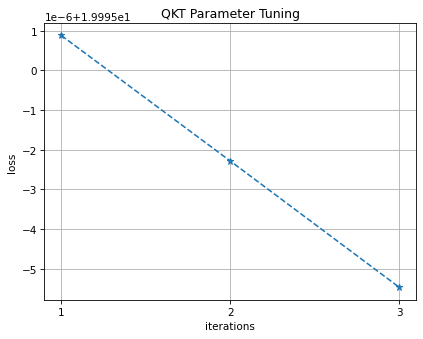

In [42]:
plt.figure(dpi=75)
plt.plot(np.arange(len(plot_data[0]))+1, plot_data[2],marker='*',ls='--')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('QKT Parameter Tuning')
plt.grid()
plt.xticks(np.arange(1,iter+1,1))
plt.savefig(f"kernel_log/{fname}/QKT loss.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [43]:
# Testing on Balanced Data
start_timer = time.time()
current_time = datetime.datetime.now()
Time = current_time.time().__str__()[:8].replace(":",".")

print(f'Starting Time: {Time}\n\n')

labelsTest = qsvckt.predict(X_test_bal)

end_timer = time.time()

time_taken = (end_timer - start_timer)/60
print(f'Time taken for testing {time_taken.__round__(2)} mins\n')

test_metrics = metrics.classification_report(y_true=y_test_bal, y_pred=labelsTest, zero_division=0)
rocauc = round(roc_auc_score(y_test_bal, labelsTest),2)

with open(f'kernel_log/{fname}/{txt_name}', "a") as f:
    f.write(f'Results after testing on Balanced Data for {len(Xtest)} data points.\n\n')
    f.write(f'Time: {Time}\n\n')
    f.write(f'{test_metrics}\n')
    f.write(f'Time taken for testing = {time_taken.__round__(2)} mins.\n')
    f.write(f'ROC AUC Score: {rocauc}\n\n')
    print(test_metrics)
    print(f'ROC AUC Score: {rocauc}')

Starting Time: 14.57.06


Time taken for testing 1.4 mins

              precision    recall  f1-score   support

         0.0       0.95      0.70      0.81        30
         1.0       0.76      0.97      0.85        30

    accuracy                           0.83        60
   macro avg       0.86      0.83      0.83        60
weighted avg       0.86      0.83      0.83        60

ROC AUC Score: 0.83


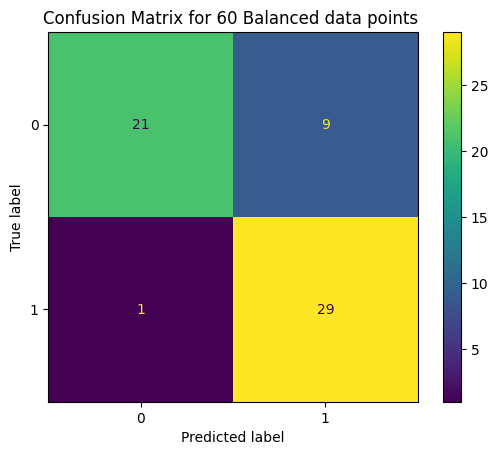

In [45]:
# Confusion Matirx for Balanced Data 
confusionMatrix = metrics.confusion_matrix(y_true=y_test_bal, y_pred=labelsTest)
disp = metrics.ConfusionMatrixDisplay(confusionMatrix)
disp.plot()
plt.title(f"Confusion Matrix for {len(X_test_bal)} Balanced data points ")
plt.savefig(f"kernel_log/{fname}/Confusion Matrix bal_{len(X_test_bal)}.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [52]:
# Testing on Imbalanced Data
start_timer = time.time()
current_time = datetime.datetime.now()
Time = current_time.time().__str__()[:8].replace(":",".")

print(f'Starting Time: {Time}\n\n')

labelsTest_imb = qsvckt.predict(X_test_imb)

end_timer = time.time()

time_taken = (end_timer - start_timer)/60
print(f'Time taken for testing {time_taken.__round__(2)} mins\n')

test_metrics_imb = metrics.classification_report(y_true=y_test_imb, y_pred=labelsTest_imb, zero_division=0)


Starting Time: 15.16.50


Time taken for testing 1.34 mins



In [57]:
# if 1.0 in y_test_imb:
rocauc_imb = round(roc_auc_score(y_test_imb, labelsTest_imb),2)
# else:
#     rocauc_imb = f'Only one class present in y_true. ROC AUC score is not defined in that case.'

with open(f'kernel_log/{fname}/{txt_name}', "a") as f:
#     f.write(f'Results after testing on Imbalanced Data for {no_test_samples} data points.\n\n')
    f.write(f'Time: {Time}\n\n')
    f.write(f'{test_metrics_imb}\n')
    f.write(f'Time taken for testing = {time_taken.__round__(2)} mins.\n')
    f.write(f'ROC AUC Score: {rocauc_imb}\n\n')
    print(test_metrics_imb)
    print(f'ROC AUC Score: {rocauc_imb}')

              precision    recall  f1-score   support

         0.0       0.97      0.60      0.74        53
         1.0       0.22      0.86      0.35         7

    accuracy                           0.63        60
   macro avg       0.60      0.73      0.55        60
weighted avg       0.88      0.63      0.70        60

ROC AUC Score: 0.73


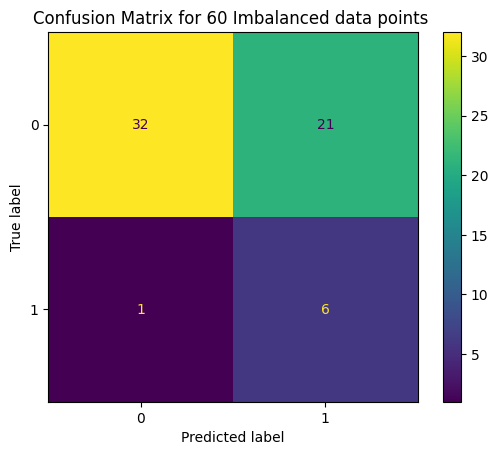

In [54]:
# Confusion Matirx for Balanced Data 
confusionMatrix = metrics.confusion_matrix(y_true=y_test_imb, y_pred=labelsTest_imb)
disp = metrics.ConfusionMatrixDisplay(confusionMatrix)
disp.plot()
plt.title(f"Confusion Matrix for {len(X_test_imb)} Imbalanced data points ")
plt.savefig(f"kernel_log/{fname}/Confusion Matrix Imbal_{len(X_test_imb)}.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [55]:
y_test_imb

103186    0.0
186884    0.0
59874     0.0
8966      0.0
73297     0.0
279483    0.0
79064     0.0
44075     0.0
29769     0.0
47414     0.0
104953    0.0
153685    0.0
117131    0.0
98221     0.0
275046    0.0
55791     0.0
59648     0.0
105483    0.0
129679    0.0
48989     0.0
225530    0.0
57326     0.0
26883     0.0
273594    0.0
112291    0.0
39658     0.0
174890    0.0
210855    0.0
89204     0.0
223058    0.0
275633    0.0
212635    0.0
177065    0.0
212363    0.0
47907     0.0
86660     0.0
261342    0.0
76658     0.0
81464     0.0
66071     0.0
62506     0.0
259445    0.0
224340    0.0
51644     0.0
121590    0.0
177897    0.0
274068    0.0
128631    0.0
217760    0.0
135366    0.0
105380    0.0
10851     0.0
5119      0.0
96994     1.0
18773     1.0
11710     1.0
41569     1.0
46909     1.0
275992    1.0
20198     1.0
Name: Class, dtype: float64